CREAZIONE PORTAFOGLI E MISURE DI RISCHIO-RENDIMENTO


--- FASE 2: Ottimizzazione P9 (MV) e P10 (RP) ---

MATRICE DI ALLOCAZIONE - PORTAFOGLI COMPLETI (P1-P10)
Periodo: 2011-08-19 → 2025-10-30
 Portafoglio    SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin    Totale (Controllo)
     P1         11.11     11.11        11.11      11.11     11.11    11.11    11.11        11.11         11.11           100.00
     P2         12.00     12.00        12.00      12.00     12.00     0.00     0.00        40.00         0.00            100.00
     P3         16.00     16.00        16.00      16.00     16.00     0.00     0.00        20.00         0.00            100.00
     P4         50.00     20.00        15.00       7.50      7.50     0.00     0.00         0.00         0.00            100.00
     P5         35.00     14.00        10.50       5.25      5.25     0.00     0.00        30.00         0.00            100.00
     P6         20.00     20.00        20.00       0.00      0.00    20.00     0.00    

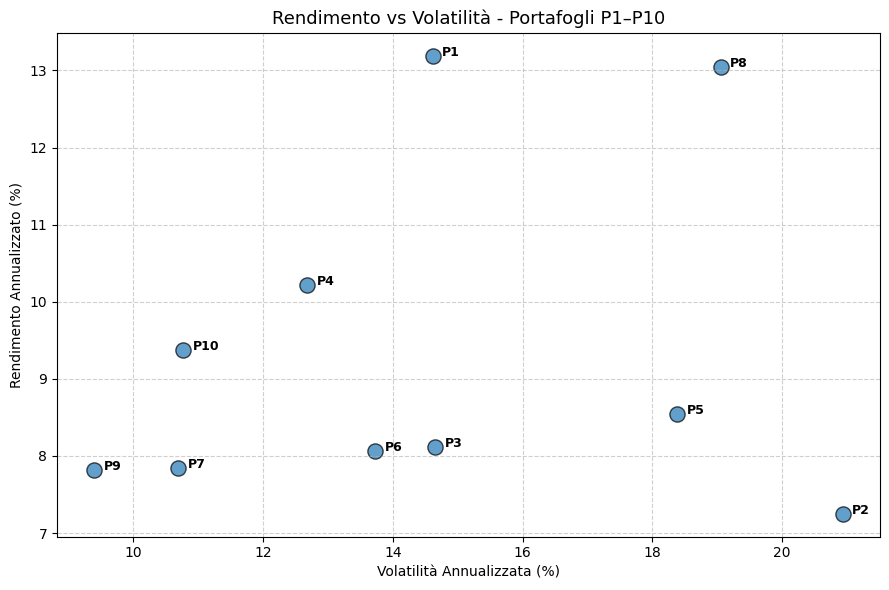

In [9]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from scipy.optimize import minimize
import warnings

# Si disabilitano i warning di SciPy e ottimizzazione per chiarezza
warnings.filterwarnings("ignore")

# --- CONFIGURAZIONE GLOBALE ---
FILE_NAME = 'indici_tesi_all.xlsx'
BASE_ASSETS = ['SP500', 'STOXX600', 'NIKKEI225', 'Sensex', 'CSI300', 'Gold', 'Silver', 'Treasury 10y']
ORDERED_P_IDS = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
TRADING_DAYS_YEAR = 252
RISK_FREE_RATE = 0.02 # Tasso risk-free annualizzato (es. 2%)

# --- FUNZIONI DI OTTIMIZZAZIONE E RISCHIO (P9, P10) ---

def portfolio_volatility(weights, returns_df):
    """Calcola la volatilità annualizzata di un portafoglio (da minimizzare per P9)."""
    if returns_df.empty: return np.inf
    # Per i log-rendimenti, usiamo cov. values
    cov_matrix = returns_df.cov().values
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(TRADING_DAYS_YEAR)
    return vol

# P9: Minima Varianza (MV)
def optimize_min_variance(returns_df):
    """Calcola i pesi statici del portafoglio a Minima Varianza (P9)."""
    n = returns_df.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    initial_weights = np.array([1/n] * n)

    try:
        opt_results = minimize(
            portfolio_volatility,
            initial_weights,
            args=(returns_df,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )
        return opt_results.x if opt_results.success else initial_weights
    except Exception:
        return initial_weights

# P10: Risk Parity (RP)
def calculate_asset_contribution_to_risk(weights, returns_df):
    """Calcola il Contributo Totale al Rischio (CRT) per ogni asset."""
    weights = np.array(weights)
    cov_matrix = returns_df.cov().values

    port_vol = portfolio_volatility(weights, returns_df) / np.sqrt(TRADING_DAYS_YEAR)
    if port_vol == 0: return np.zeros_like(weights)

    # Contributo marginale al rischio (MCR)
    mcr = np.dot(cov_matrix, weights) / port_vol

    # Contributo totale al rischio (CRT)
    crt = weights * mcr
    return crt * np.sqrt(TRADING_DAYS_YEAR)

def risk_parity_objective(weights, returns_df):
    """Funzione obiettivo per minimizzare la deviazione dal Risk Parity (P10)."""
    if np.sum(weights) == 0: return np.inf

    crt = calculate_asset_contribution_to_risk(weights, returns_df)
    n_assets = len(weights)
    target_risk_contribution = np.sum(crt) / n_assets

    # Minimizzo la somma delle deviazioni al quadrato tra i CR
    return np.sum((crt - target_risk_contribution)**2)

def optimize_risk_parity(returns_df):
    """Calcola i pesi statici del portafoglio a Risk Parity (P10)."""
    n = returns_df.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    initial_weights = np.array([1/n] * n)

    try:
        opt_results = minimize(
            risk_parity_objective,
            initial_weights,
            args=(returns_df,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'ftol': 1e-7}
        )
        return opt_results.x if opt_results.success else initial_weights
    except Exception:
        return initial_weights

# --- FUNZIONE DI DEFINIZIONE DEI PESI (Completa) ---

def define_all_portfolio_weights(returns_df, p9_weights_array, p10_weights_array):
    """Crea il DataFrame che contiene tutti i pesi P1-P10, inclusi P9 e P10 ottimizzati."""

    assets = returns_df.columns.tolist()
    AZIONARI = [a for a in assets if a not in ['Gold', 'Silver', 'Treasury 10y', 'Bitcoin']]
    N_AZ = len(AZIONARI)
    w_az_eq = 1 / N_AZ if N_AZ > 0 else 0

    all_weights = {}

    # P1: Equi-Ponderato Globale (EW)
    all_weights['P1'] = pd.Series([1/len(assets)] * len(assets), index=assets)

    # P2: 60/40 Tradizionale & P3: 80/20 Aggressivo
    w_p2 = pd.Series(0.0, index=assets); w_p3 = pd.Series(0.0, index=assets)
    for a in AZIONARI:
        w_p2[a] = 0.60 * w_az_eq
        w_p3[a] = 0.80 * w_az_eq
    if 'Treasury 10y' in assets:
        w_p2['Treasury 10y'] = 0.40
        w_p3['Treasury 10y'] = 0.20
    all_weights['P2'] = w_p2
    all_weights['P3'] = w_p3

    # P4 & P5 (Geografici)
    w_p4 = pd.Series(0.0, index=assets); w_p5 = pd.Series(0.0, index=assets)
    weights_p6 = {'SP500': 0.50, 'STOXX600': 0.20, 'NIKKEI225': 0.15, 'Sensex': 0.075, 'CSI300': 0.075}
    for asset, weight in weights_p6.items():
        if asset in assets:
            w_p4[asset] = weight
            w_p5[asset] = 0.70 * weight
    if 'Treasury 10y' in assets: w_p5['Treasury 10y'] = 0.30
    all_weights['P4'] = w_p4; all_weights['P5'] = w_p5

    # P6: Focus Sviluppati
    assets_p4 = [a for a in ['SP500', 'STOXX600', 'NIKKEI225', 'Treasury 10y', 'Gold'] if a in assets]
    w_p6 = pd.Series(0.0, index=assets)
    if assets_p4: w_p6[assets_p4] = 1 / len(assets_p4)
    all_weights['P6'] = w_p6

    # P7: Difesa Commodities
    w_p7 = pd.Series(0.0, index=assets)
    for a in AZIONARI: w_p7[a] = 0.80 * w_az_eq
    if 'Gold' in assets: w_p7['Gold'] = 0.10
    if 'Silver' in assets: w_p7['Silver'] = 0.10
    all_weights['P7'] = w_p7

    # P8: Esposizione Bitcoin
    w_p8 = pd.Series(0.0, index=assets)
    for a in AZIONARI: w_p8[a] = 0.60 * w_az_eq
    if 'Treasury 10y' in assets: w_p8['Treasury 10y'] = 0.30
    if 'Bitcoin' in assets: w_p8['Bitcoin'] = 0.10
    all_weights['P8'] = w_p8

    # P9: Minima Varianza Statica (MV) - Ottimizzato
    all_weights['P9'] = pd.Series(p9_weights_array, index=assets)

    # P10: Risk Parity (RP) - Ottimizzato
    all_weights['P10'] = pd.Series(p10_weights_array, index=assets)

    df_weights = pd.DataFrame(all_weights).T.fillna(0.0)
    df_weights.index.name = 'Portafoglio'

    return df_weights.reindex(ORDERED_P_IDS)


# --- FUNZIONI DI ANALISI FINALE (MDD, SHARPE) ---

def calculate_max_drawdown(returns_series):
    """Calcola il Max Drawdown da una serie di rendimenti logaritmici."""
    simple_returns = np.exp(returns_series) - 1
    cumulative_returns = (1 + simple_returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns / peak) - 1
    return drawdown.min() * 100

def calculate_annual_metrics(returns_series, risk_free_rate_annual):
    """Calcola Rendimento, Volatilità e Sharpe Ratio annualizzati (usando rendimenti log)."""

    annual_return = returns_series.mean() * TRADING_DAYS_YEAR
    annual_volatility = returns_series.std() * np.sqrt(TRADING_DAYS_YEAR)

    if annual_volatility == 0:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_volatility

    return annual_return * 100, annual_volatility * 100, sharpe_ratio

# --- MAIN SCRIPT ---

if __name__ == "__main__":

    # 1. Caricamento e Pulizia Iniziale dei Dati
    try:
        df_prezzi = pd.read_excel(FILE_NAME)
        df_prezzi['Date'] = pd.to_datetime(df_prezzi['Date'])
        df_prezzi.set_index('Date', inplace=True)
    except FileNotFoundError:
        print(f"❌ ERRORE: File '{FILE_NAME}' non trovato.")
        exit()

    df_returns = np.log(df_prezzi / df_prezzi.shift(1)).replace([np.inf, -np.inf], np.nan)

    if 'Bitcoin' in df_returns.columns:
        ALL_ASSETS = BASE_ASSETS + ['Bitcoin']
    else:
        ALL_ASSETS = BASE_ASSETS

    df_returns_final = df_returns[ALL_ASSETS].dropna(how='all').dropna(how='any')
    if df_returns_final.empty:
        print("❌ Dataset vuoto dopo la pulizia. Impossibile creare i portafogli.")
        exit()

    # 2. Calcolo P9 e P10 (Ottimizzazione)
    print("\n--- FASE 2: Ottimizzazione P9 (MV) e P10 (RP) ---")

    P9_weights_array = optimize_min_variance(df_returns_final)
    P10_weights_array = optimize_risk_parity(df_returns_final)

    # 3. Creazione e Presentazione della Matrice Completa dei Pesi
    df_weights_complete = define_all_portfolio_weights(
        df_returns_final,
        P9_weights_array,
        P10_weights_array
    )

    df_weights_complete['Totale (Controllo)'] = df_weights_complete.sum(axis=1)

    # Stampa Matrice dei Pesi
    df_weights_presentation = (df_weights_complete * 100).round(2)

    print("\n" + "="*100)
    print("MATRICE DI ALLOCAZIONE - PORTAFOGLI COMPLETI (P1-P10)")
    print("Periodo:", df_returns_final.index.min().date(), "→", df_returns_final.index.max().date())
    print("="*100)

    df_display = df_weights_presentation.copy()
    table_str = tabulate(
        df_display.reset_index(),
        headers=["Portafoglio"] + df_display.columns.tolist(),
        tablefmt="plain",
        showindex=False,
        numalign="center",
        stralign="center",
        floatfmt=".2f"
    )
    print(table_str)

    # --- FASE 4: Analisi di Performance e Rischio ---

    # Calcolo dei Rendimenti Aggregati del Portafoglio
    df_portfolio_returns = df_returns_final.dot(df_weights_complete[ALL_ASSETS].T)

    # Calcolo della Sintesi (Le 4 Metriche Essenziali)
    results = {}
    for p_id in ORDERED_P_IDS:
        returns_series = df_portfolio_returns[p_id].dropna()
        if returns_series.empty: continue

        ann_ret, ann_vol, sharpe = calculate_annual_metrics(returns_series, RISK_FREE_RATE)
        max_dd = calculate_max_drawdown(returns_series)

        results[p_id] = {
            'Rendimento Ann. (%)': ann_ret,
            'Volatilità Ann. (%)': ann_vol,
            'Max Drawdown (%)': max_dd,
            'Sharpe Ratio': sharpe
        }

    df_summary = pd.DataFrame(results).T.round(2)

    # Stampa Tabella di Sintesi Finale
    print("\n\n" + "="*100)
    print("SINTESI DI PERFORMANCE E RISCHIO - PORTAFOGLI P1-P10")
    print(f"Tasso Risk-Free (per Sharpe Ratio): {RISK_FREE_RATE*100:.1f}%")
    print("="*100)

    df_display_summary = df_summary.copy()

    column_order = ['Rendimento Ann. (%)', 'Volatilità Ann. (%)', 'Max Drawdown (%)', 'Sharpe Ratio']
    df_display_summary = df_display_summary[column_order]

    table_str_summary = tabulate(
        df_display_summary.reset_index(),
        headers=["Portafoglio"] + df_display_summary.columns.tolist(),
        tablefmt="plain",
        showindex=False,
        numalign="center",
        stralign="center",
        floatfmt=".2f"
    )
    print(table_str_summary)

    print("\n--- RIEPILOGO PER LA TESI ---")
    print(f"I modelli P9 (Minima Varianza) e P10 (Risk Parity) sono fondamentali per confrontare le strategie di allocazione statica e ottimizzata, specialmente nel Max Drawdown, che è la metrica chiave della resilienza alle crisi.")


import matplotlib.pyplot as plt

# --- GRAFICO RIASSUNTIVO: RENDIMENTO vs VOLATILITÀ ---

def grafico_rendimento_volatilita(df_summary):
    plt.figure(figsize=(9, 6))
    plt.scatter(
        df_summary['Volatilità Ann. (%)'],
        df_summary['Rendimento Ann. (%)'],
        s=120, alpha=0.7, edgecolors='black'
    )

    # Etichette per ciascun portafoglio
    for i, label in enumerate(df_summary.index):
        plt.text(
            df_summary['Volatilità Ann. (%)'][i] + 0.15,
            df_summary['Rendimento Ann. (%)'][i],
            label,
            fontsize=9,
            weight='bold'
        )

    plt.title("Rendimento vs Volatilità - Portafogli P1–P10", fontsize=13)
    plt.xlabel("Volatilità Annualizzata (%)")
    plt.ylabel("Rendimento Annualizzato (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Mostra il grafico solo se ci sono dati
if not df_summary.empty:
    grafico_rendimento_volatilita(df_summary)
